In [14]:
from google.colab import files
uploaded = files.upload()

Saving customer_shopping_data.csv to customer_shopping_data (2).csv


In [15]:
import pandas as pd

# Load CSV
df = pd.read_csv('customer_shopping_data.csv')

# Preprocess
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True, errors='coerce')
df['total_sales'] = df['quantity'] * df['price']
df.dropna(subset=['invoice_date'], inplace=True)

# Daily sales
daily_sales = df.groupby('invoice_date')['total_sales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

In [16]:
from prophet import Prophet

model = Prophet()
model.fit(daily_sales)

# Forecast next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdo5x33k/jt3bndoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdo5x33k/wstv_lzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70056', 'data', 'file=/tmp/tmptdo5x33k/jt3bndoh.json', 'init=/tmp/tmptdo5x33k/wstv_lzi.json', 'output', 'file=/tmp/tmptdo5x33k/prophet_modelxsdhfcxp/prophet_model-20250619160003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:00:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


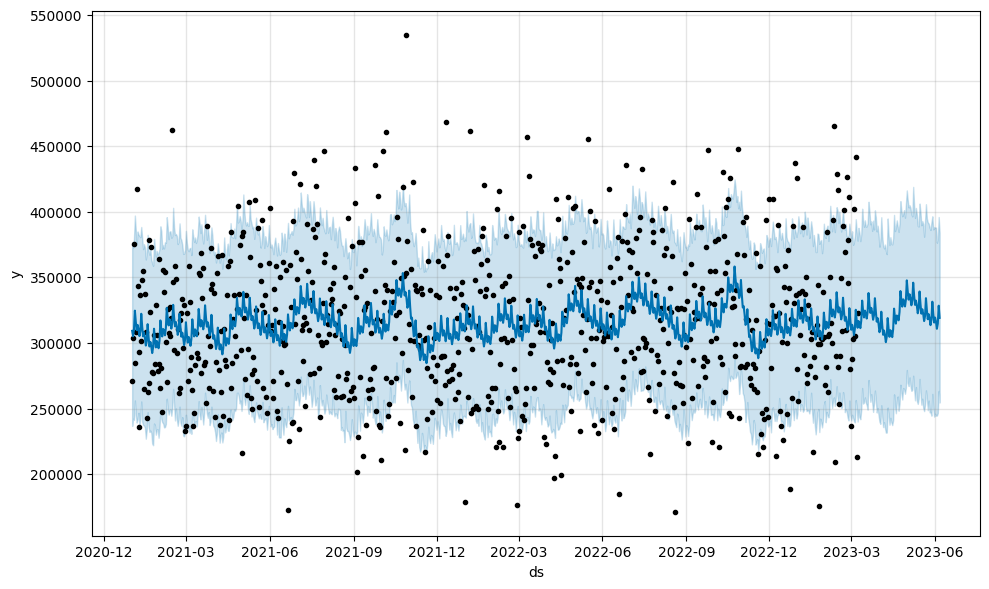

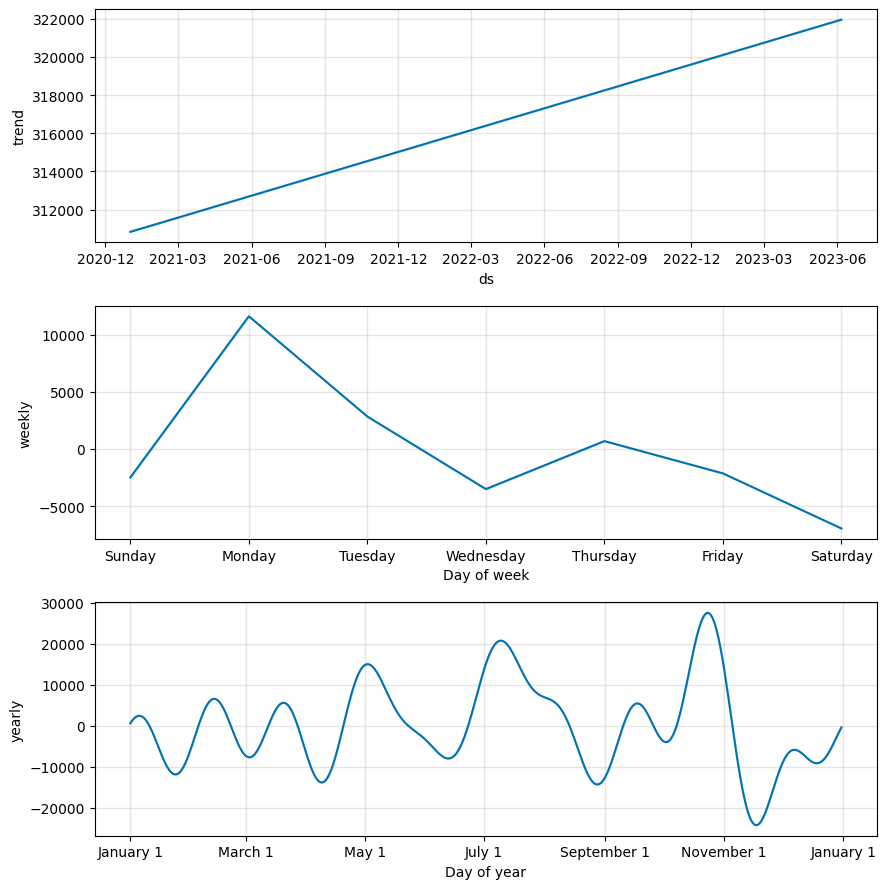

In [17]:
import matplotlib.pyplot as plt

# Forecast plot
fig1 = model.plot(forecast)
plt.show()

# Seasonality + trend
fig2 = model.plot_components(forecast)
plt.show()
model.plot_components(forecast)

In [22]:
# Split data for evaluation
train = daily_sales[:-30]
test = daily_sales[-30:]

# Re-fit model on train data
model = Prophet()
model.fit(train)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Merge with actual values
comparison = forecast[['ds', 'yhat']].merge(test, on='ds')
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdo5x33k/10wgaw9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdo5x33k/9f726kn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4686', 'data', 'file=/tmp/tmptdo5x33k/10wgaw9o.json', 'init=/tmp/tmptdo5x33k/9f726kn3.json', 'output', 'file=/tmp/tmptdo5x33k/prophet_modelns2ftty3/prophet_model-20250619160247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 59848.42, RMSE: 74369.48


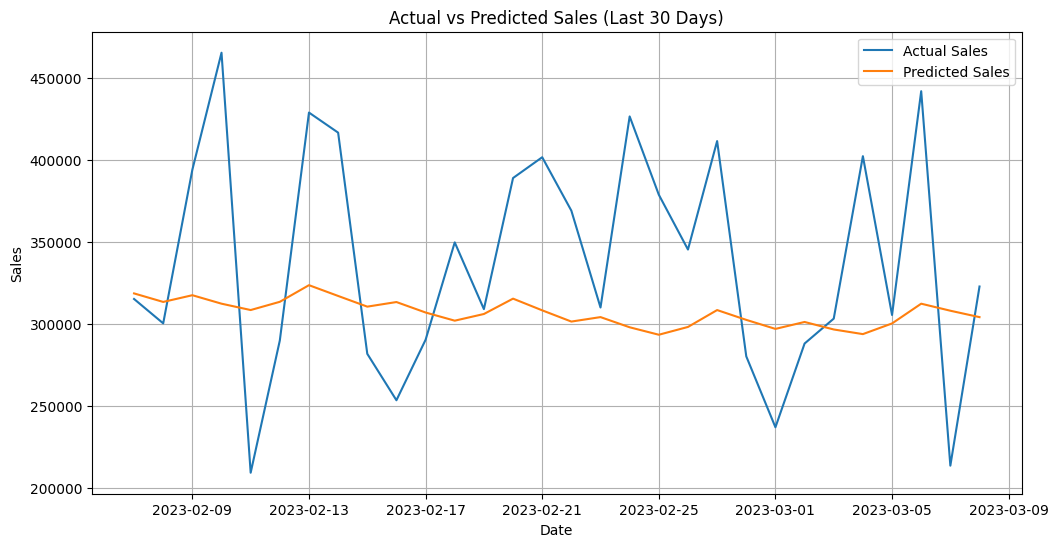

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], label='Actual Sales')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted Sales')
plt.title('Actual vs Predicted Sales (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

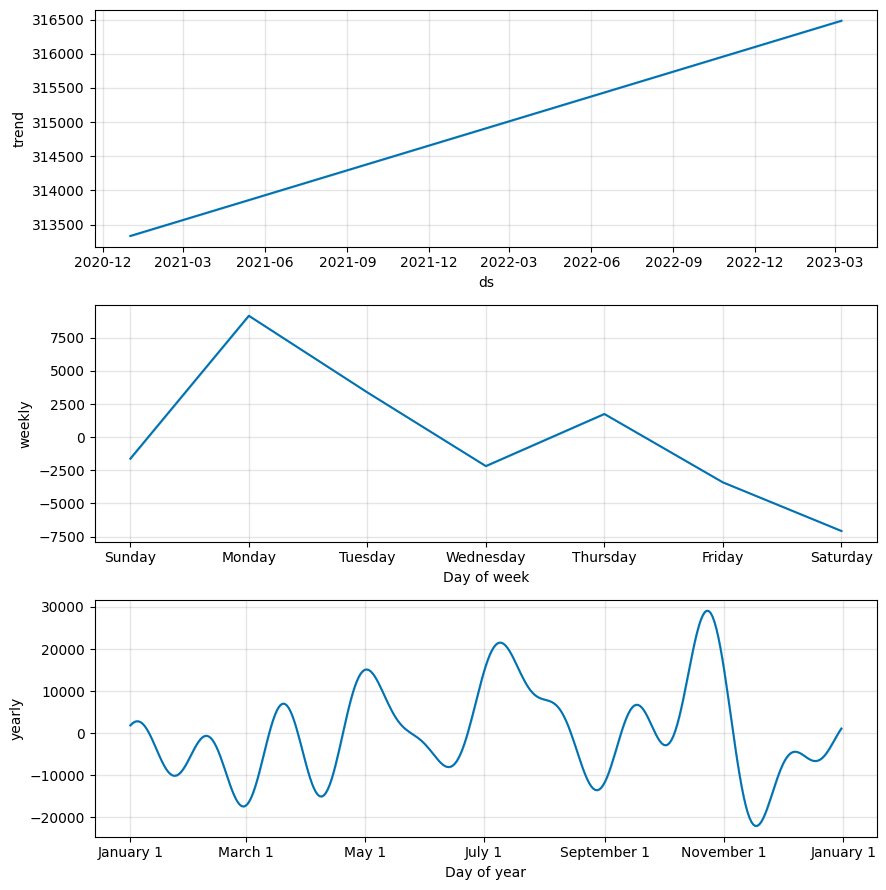

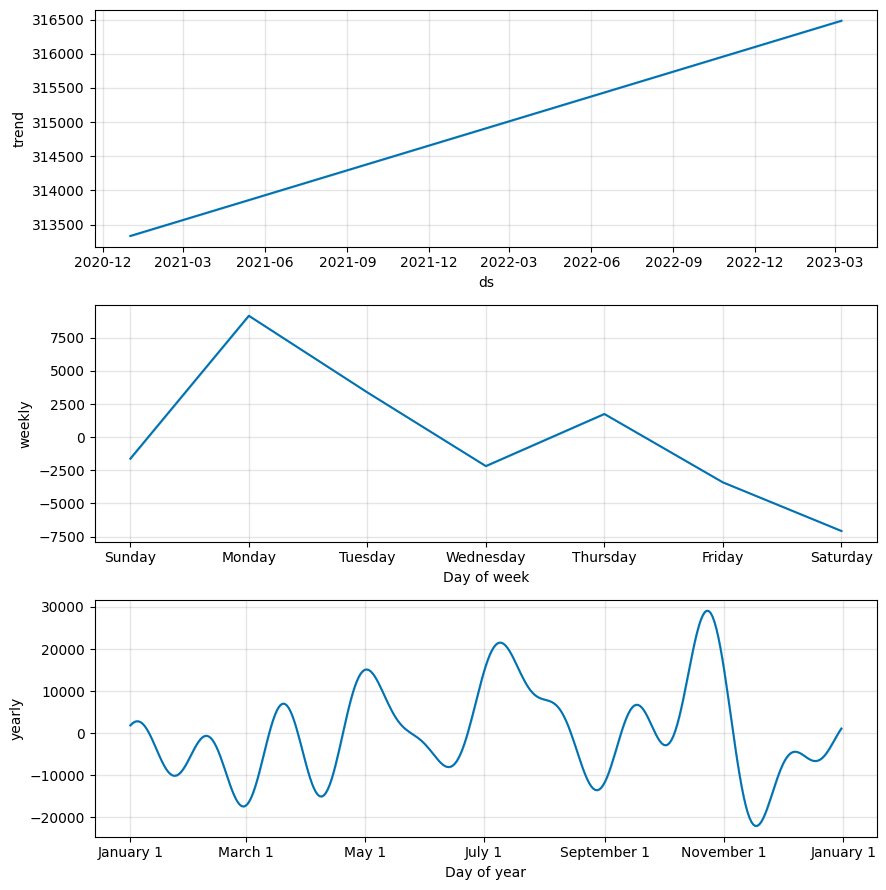

In [25]:
model.plot_components(forecast)

In [26]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('sales_forecast.csv', index=False)
files.download('sales_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>